# Trabajo Práctico 3 - Detectando atributos de personas

## Dataset: CelebFaces Attributes (CelebA)

_"Este conjunto de datos es excelente para entrenar y probar modelos para la detección de rostros, particularmente para reconocer atributos faciales, como encontrar personas con cabello castaño, sonriendo o usando anteojos. Las imágenes cubren grandes variaciones de poses, desorden de fondo, personas diversas, respaldadas por una gran cantidad de imágenes y ricas anotaciones."_

Usaremos este set de datos para entrenar distintos modelos que puedan identificar si la imagen de un rostro humano tiene barba o no.

In [1]:
# Importamos las dependencias que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

from pathlib import Path
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Bajamos el nivel de warning de TF

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, Xception # modelos pre-entrenados
from tensorflow.keras.preprocessing import image
from tensorflow.keras import metrics

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score
from sklearn.utils import compute_class_weight

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)

In [5]:
ROOT = 'D:/HDD_Documents/Universidad/En_curso/MachineLearning/CelebA'
IMAGES_DIR = Path(os.path.join(ROOT, 'img_align_celeba'))

In [6]:
df_attributes = pd.read_csv(os.path.join(ROOT,'list_attr_celeba.csv'))
df_attributes.set_index('image_id')

df_partition = pd.read_csv(os.path.join(ROOT, 'list_eval_partition.csv'))
df_partition.set_index('image_id')

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,2
202596.jpg,2
202597.jpg,2


In [7]:
# Merge del dataset de atributos con el dataset que divide los datos en train, test y validation
full = pd.merge(df_attributes, df_partition)
full = full[['image_id', 'No_Beard', 'partition']]
full.set_index('image_id')

,No_Beard,partition
image_id,,
000001.jpg,1,0
000002.jpg,1,0
000003.jpg,1,0
000004.jpg,1,0
000005.jpg,1,0
...,...,...
202595.jpg,1,2
202596.jpg,1,2
202597.jpg,1,2


In [8]:
full.loc[full['No_Beard'] == -1, 'No_Beard'] = 0 # Pasamos a 0 y 1 la feature No_Beard
full['No_Beard'] = full['No_Beard'].astype(str) # Lo paso a string para que el datagen no me de error

## 1. Análisis exploratorio de datos
### Volumetría, estructura y tipo de las imágenes
El conjunto de datos está compuesto de la siguiente forma:
* __Cantidad:__ 202599 imágenes
* __Formato:__ todas las imágenes se encuentran en formato JPG
* __Dimensiones:__ Ancho 178px - Alto 218px - Canales 3 (RGB)

In [7]:
len(os.listdir(IMAGES_DIR))

202599

In [8]:
extensions = set()
for filename in os.listdir(IMAGES_DIR):
    extensions.add(Path(filename).suffix.lower())
    
extensions

{'.jpg'}

In [9]:
img = image.load_img(os.path.join(IMAGES_DIR, '000001.jpg'))
img.size, image.img_to_array(img).shape[2]
# ((ancho, alto), canales)

((178, 218), 3)

In [10]:
# Tenemos 202599 imágenes, todas en formato jpg
# Ancho: 178px - Alto: 218px - Canales: 3 (RGB)
# Cada imagen tiene  40 atributos asociados a través del ID, solamente vamos a usar el atributo No_Beard

### Distribución de los datos
Hicimos la separación del set de datos en train, validation y test según lo recomendado en el dataset.
De esta forma, aproximadamente el 80% de los datos pertenecen a __Train__, mientras que lo restante se divide entre __Validation y Test__ en partes casi iguales.

(162770, 3) (19867, 3) (19962, 3)


<Axes: ylabel='count'>

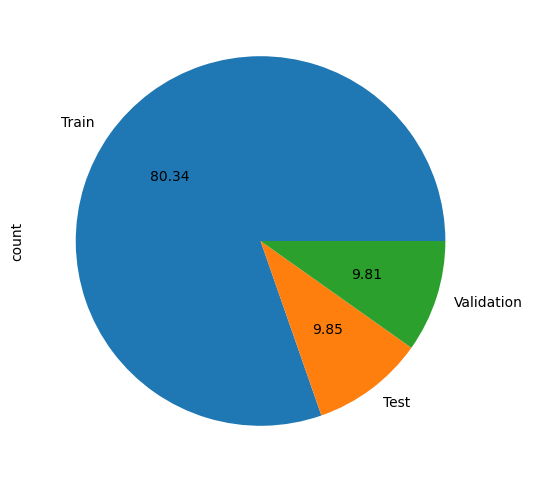

In [11]:
# Hacemos la separación en train, validation y test como se indica en el dataset 
df_train = full[full.partition == 0]
df_validation = full[full.partition == 1]
df_test = full[full.partition == 2]

print(df_train.shape, df_validation.shape, df_test.shape)
full.partition.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['Train', 'Test', 'Validation'])

### Distribución de la variable a predecir: No_Beard
La variable a predecir 'No_Beard' es una variable binaria, donde el valor 1 indica que la persona de la imagen no tiene barba, mientras que un 0 indica que sí tiene barba.

En el gráfico de torta podemos ver que claramente el set de datos se encuentra desbalanceado respecto a la variable a predecir, ya que un __83.49%__ de las imágenes contienen rostros de personas sin barba, habiendo solamente un __16.51%__ de personas con barba.

<Axes: ylabel='count'>

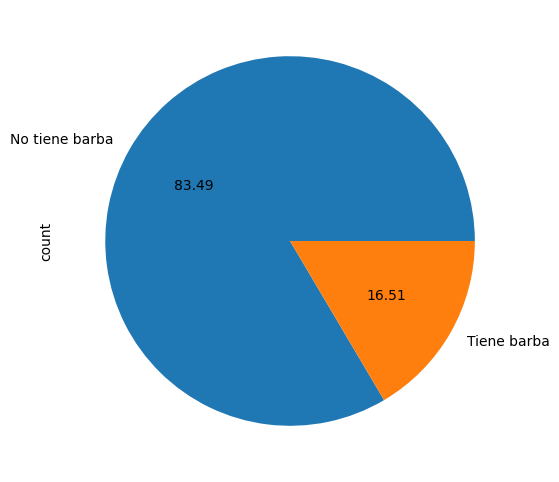

In [12]:
# Distribución en la totalidad del dataset
full.No_Beard.value_counts().plot.pie(autopct='%.2f',figsize=(6,6), labels=['No tiene barba', 'Tiene barba'])

#### Distribución de la variable a predecir en los set de datos de train, validation y test
Realizamos este análisis para ver que la separación de los datos recomendadas por el dataset mantienen la distribución de la feature 'No_Beard'. Podemos ver que varía un poco entre estos, pero la distribución de la variable a predecir de todo el dataset se mantiene de forma similar.

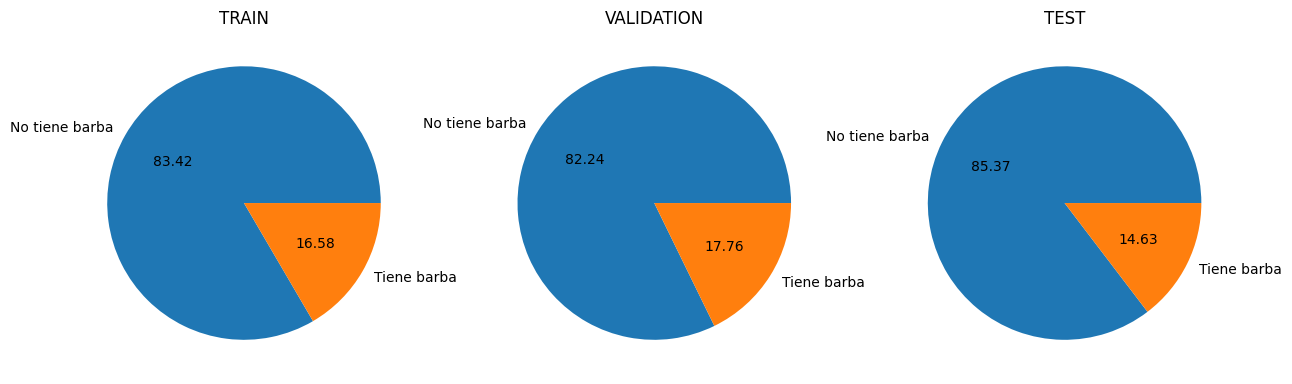

In [13]:
# Comparacion de la distribucion de 'No_Beard' en los tres subsets.
# Hacemos este análisis ya que no sabemos cómo hicieron la separación en los tres datasets,
# para ver si se mantiene la distribución de la variable de salida
fig, axis = plt.subplots(1,3, figsize=(15,10))
axis[0].pie(df_train.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[0].set_title('TRAIN')
axis[1].pie(df_validation.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[1].set_title('VALIDATION')
axis[2].pie(df_test.No_Beard.value_counts(), autopct='%.2f', labels=['No tiene barba', 'Tiene barba'])
axis[2].set_title('TEST')

plt.show()

In [13]:
# Creamos los datasets de keras
SIZE = 96 # Vamos a ir probando distintos tamaños... usaremos el mayor tamaño posible que se entrene en tiempo razonable

datagen = ImageDataGenerator(rescale=1./255)

GENERATOR_PARAMS = dict(
    directory=IMAGES_DIR,
    x_col='image_id',
    y_col='No_Beard',
    target_size=(SIZE,SIZE),
    class_mode='binary',
    color_mode="rgb",
)

train = datagen.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS)

validation = datagen.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS)

test = datagen.flow_from_dataframe(dataframe=df_test, **GENERATOR_PARAMS)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


In [2]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(np.where(labels[i] == 1, 'Sin barba', 'Con Barba'))
        plt.axis("off")

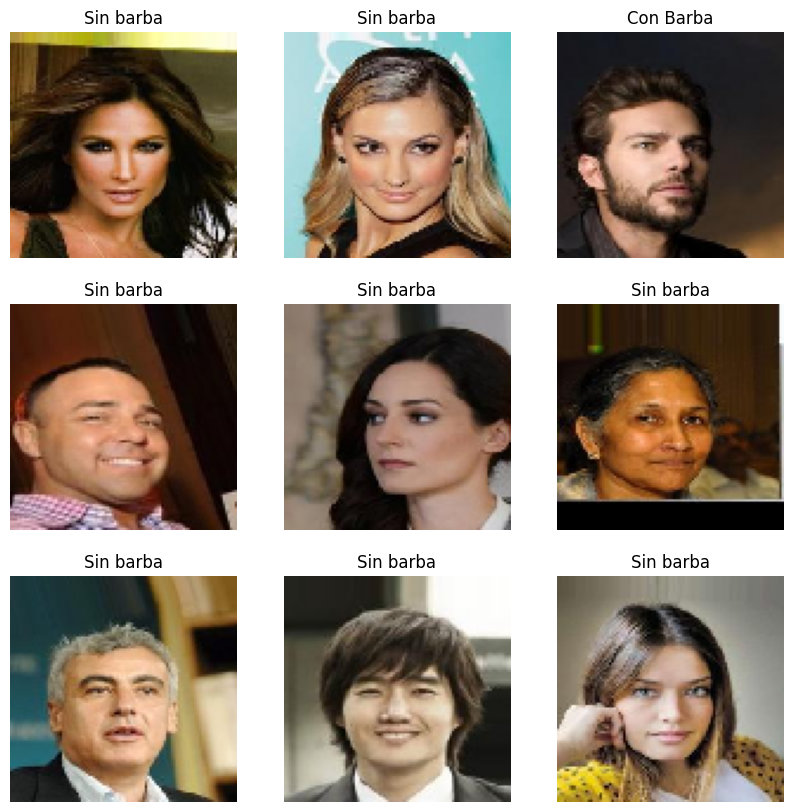

In [16]:
sample_images(test)

## 2. Machine Learning
En la etapa de entrenamiento fuimos probando distintas arquitecturas en los distintos modelos para compararlos entre sí.

Configuración general de los modelos:

__Reescalado de imágenes:__ realizamos un reescalado para que los valores vayan entre 0 y 1.

Disminuimos el tamaño de las imágenes de entrada para el entrenamiento a 96*96 pixeles.

__input_shape:__ (96x96x3) --> 27,648

__Tamaño del batch:__ 64

__Optimizador:__ adam

__Función de error:__ binary crossentropy

__steps_per_epoch:__ tamaño set de datos de entrenamiento / tamaño del batch --> 162770 / 64 = 2543

__validation_steps:__ tamaño set de datos de validación / tamaño del batch --> 19867 / 64 = 310

__class_weight:__ al estar la variable a predecir desbalanceada como lo vimos anteriormente, ajustamos los pesos asignados a estas clases para que durante el entrenamiento el error del valor desbalanceado (cuando tiene barba) tenga más impacto. Para esto usamos la función 'compute_class_weight' de sklearn, donde nos devuelve los pesos para cada clase de forma balanceada.

In [17]:
# Funciones a utilizar durante el entrenamiento para luego evaluar los modelos
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [18]:
def learning_curve(history):
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='validation')
  plt.title('Accuracy over train epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()

In [128]:
datasets = (
    ('train', datagen.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS, batch_size=1000)),
    ('validation', datagen.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS, batch_size=1000)),
)

def print_cofusion_matrix(model):
    for dataset_name, dataset in datasets:
        print('#' * 25, dataset_name, '#' * 25)

        batch_images, batch_labels = dataset.next()
        print('Samples:', len(batch_images))

        predictions = np.round(model.predict(batch_images)).flatten()
        labels = batch_labels
        
        print('Accuracy:', accuracy_score(labels, predictions))
        print('Precision:', precision_score(labels, predictions))
        print('ROC-AUC Score:', roc_auc_score(labels,predictions))

        VALORES = "Beard", "No Beard"
        
        plt.figure(figsize=(6,6))
        
        sns.heatmap(confusion_matrix(labels, predictions), annot=True, cmap='Greens', xticklabels=VALORES, yticklabels=VALORES, fmt='g')
        plt.xlabel('Predicted value')
        plt.ylabel('True value')
        plt.title('Confusion Matrix')
        plt.show()

In [20]:
# Al final no la usamos
def set_model_best_weight(history, model):
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])
    model.set_weights(model_weights_at_epochs[best_val_acc_epoch])
    print('Mejor época:',best_val_acc_epoch)
    print('val_accuracy:',history.history['val_accuracy'][best_val_acc_epoch])

In [21]:
BATCH_SIZE = 64

COMPILE_PARAMS = dict(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# Obtengo el peso que le vamos a asignar a cada clase a la hora de entrenar, para manejar el desbalance del target
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(train.classes),y=train.classes)
class_weights = dict(zip(np.unique(train.classes), class_weights))

FIT_PARAMS = dict(
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train)/BATCH_SIZE,
    validation_steps=len(validation)/BATCH_SIZE,
    validation_data=validation,
    callbacks=[OurCustomCallback()],
    class_weight = class_weights,
)

## Multi Layer Perceptron

Planteamos distintas arquitecturas y variamos cantidad de épocas para ir comparando las diferencias entre los modelos.

Para no repetirlo, todos los modelos tienen una capa de salida que consta de una única neurona (ya que determina si no tiene barba o si sí tiene), con función de activación Sigmoid.

#### MLP 1_1 ####
__Arquitectura:__

_Capas:_
* 1 densa de 100 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 15

#### MLP 1_2 ####
__Arquitectura:__

_Capas:_
* 1 densa de 100 neuronas. Aplica dropout del 0.25 a la salida. Activación: tanh

_Épocas:_ 15

Planteamos estas arquitecturas que sólamente difieren en la función de activación de la capa oculta para ver el efecto que tienen estas. Pudimos concluir en que ReLU otorga mejores resultados, ya que este modelo intenta identificar entre los dos posibles casos, mientras que el modelo en el que usamos tanh, sólamente clasifició como que todos los casos no tienen barba.

#### MLP 2 ####
__Arquitectura:__

_Capas:_
* Densa de 50 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 50 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20 y 40

Para este caso, entrenamos el modelo dos veces, una vez con 20 y otra con 40 épocas. Queríamos si el modelo requería de muchas épocas o si comenzaba a disminuir el rendimiento a partir que estas pasaban.
Pudimos concluir que en ambos casos el modelo no es bueno, ya que siempre clasifica a las imágenes como que no tienen barba.

#### MLP 3 ####
__Arquitectura:__

_Capas:_
* Densa de 60 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 40 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 15

Planteamos este modelo modificando la arquitectura, planteando tres capas ocultas en las que se iban disminuyendo la cantidad de neuronas en cada una de estas. El rendimiento del modelo no fue el esperado, ya que similar a los dos casos anteriores, clasifica a todos los casos como que sí tienen barba, obteniendo resultados en las métricas muy bajos.

#### MLP 4 ####
__Arquitectura:__

_Capas:_
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* Densa de 20 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20

En esta arquitectura quisimos ver como se comporta el modelo teniendo siete capas ocultas iguales. Los resultados, como en casos anteriores, no fueron para nada buenos.

De todas las arquitecturas planteadas, vemos que el más factible es el 'MLP_1_1', en el que se obtuvo un accuracy de 0.684 y un ROC-AUC Score de 0.75.
Si bien el accuracy es menor que el de los otros modelos, este intenta diferenciar entre las dos clases posibles como se puede ver en el ROC-AUC Score, por lo que le da mayor valor que a los otros.

In [22]:
# MLP

mlp_1_1 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(100, activation='relu'),
    Dropout(0.25),
                                                # aca buscamos ver si hay mucha diferencia entre las funciones de activacion
    Dense(1, activation='sigmoid'),
])

mlp_1_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

mlp_2 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),), # a este modelo lo vamos a entrenar dos veces, una vez con 10 y otra con 20 epocas

    Dense(50, activation='relu'),
    Dropout(0.25),
    Dense(50, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

mlp_3 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(60, activation='relu'),
    Dropout(0.25),
    Dense(40, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])
                                                # aca probamos otros modelos con mas capas ocultas para ver como funciona
mlp_4 = Sequential([
    Flatten(input_shape=(SIZE,SIZE,3),),

    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    Dense(20, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [23]:
# Compilamos cada uno de los modelos MLP planteados y vemos el resumen
mlp_1_1.compile(**COMPILE_PARAMS) #relu

mlp_1_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 100)               2764900   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_mlp_1_1 = mlp_1_1.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 38s 454ms/step - loss: 1.8997 - accuracy: 0.5336 - val_loss: 0.6944 - val_accuracy: 0.2750
Epoch 2/15
79/79 [==============================] - 35s 446ms/step - loss: 0.7132 - accuracy: 0.5051 - val_loss: 0.6426 - val_accuracy: 0.8344
Epoch 3/15
79/79 [==============================] - 35s 442ms/step - loss: 0.6504 - accuracy: 0.6375 - val_loss: 0.5979 - val_accuracy: 0.7375
Epoch 4/15
79/79 [==============================] - 36s 451ms/step - loss: 0.6629 - accuracy: 0.6117 - val_loss: 0.6354 - val_accuracy: 0.5906
Epoch 5/15
79/79 [==============================] - 34s 429ms/step - loss: 0.6299 - accuracy: 0.5820 - val_loss: 0.5086 - val_accuracy: 0.7750
Epoch 6/15
79/79 [==============================] - 34s 428ms/step - loss: 0.6642 - accuracy: 0.5262 - val_loss: 0.6433 - val_accuracy: 0.5188
Epoch 7/15
79/79 [==============================] - 34s 422ms/step - loss: 0.6251 - accuracy: 0.5902 - val_loss: 0.4589 - val_accuracy: 0.8219

In [25]:
#set_model_best_weight(history_mlp_1_1, mlp_1_1)

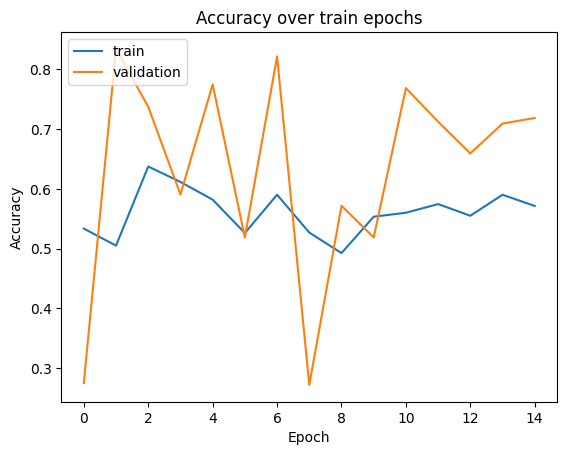

In [26]:
learning_curve(history_mlp_1_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.692
Precision: 0.9625668449197861
ROC-AUC Score: 0.7657876159389394


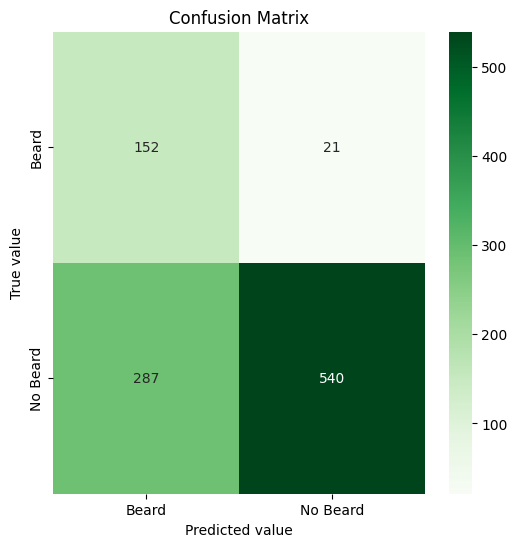

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.684
Precision: 0.9522968197879859
ROC-AUC Score: 0.7469947196944162


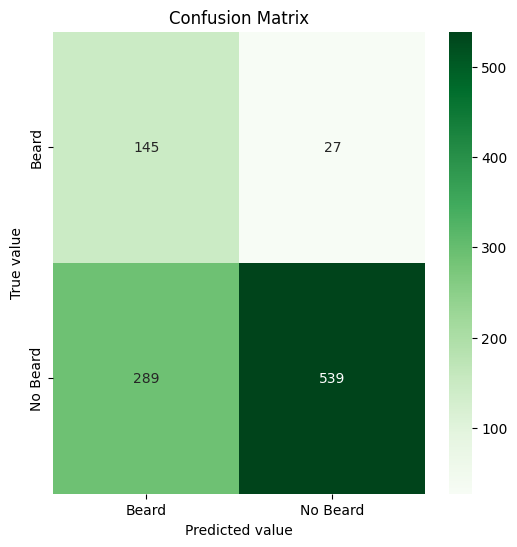

In [129]:
print_cofusion_matrix(mlp_1_1)

In [28]:
# Guardamos los pesos de la ultima epoca
mlp_1_1.save_weights("mlp_1_1.h5")

In [29]:
mlp_1_2.compile(**COMPILE_PARAMS) #tanh

mlp_1_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 27648)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               2764900   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,765,001
Trainable params: 2,765,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_mlp_1_2 = mlp_1_2.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 31s 384ms/step - loss: 2.6673 - accuracy: 0.8164 - val_loss: 0.5266 - val_accuracy: 0.8031
Epoch 2/15
79/79 [==============================] - 30s 384ms/step - loss: 0.7506 - accuracy: 0.4961 - val_loss: 0.6615 - val_accuracy: 0.8500
Epoch 3/15
79/79 [==============================] - 30s 374ms/step - loss: 0.7469 - accuracy: 0.5039 - val_loss: 0.7107 - val_accuracy: 0.1719
Epoch 4/15
79/79 [==============================] - 30s 376ms/step - loss: 0.7608 - accuracy: 0.4609 - val_loss: 0.7114 - val_accuracy: 0.1594
Epoch 5/15
79/79 [==============================] - 29s 366ms/step - loss: 0.7421 - accuracy: 0.4969 - val_loss: 0.6756 - val_accuracy: 0.4563
Epoch 6/15
79/79 [==============================] - 28s 358ms/step - loss: 0.7294 - accuracy: 0.4965 - val_loss: 0.6876 - val_accuracy: 0.7937
Epoch 7/15
79/79 [==============================] - 28s 354ms/step - loss: 0.7159 - accuracy: 0.5254 - val_loss: 0.6789 - val_accuracy: 0.8031

In [31]:
#set_model_best_weight(history_mlp_1_2, mlp_1_2)

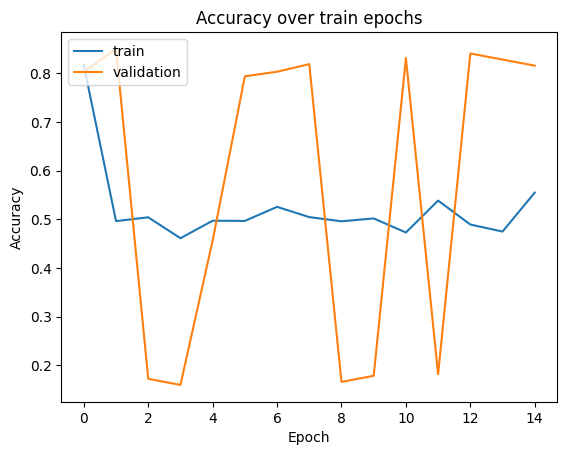

In [32]:
learning_curve(history_mlp_1_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.838
Precision: 0.838
ROC-AUC Score: 0.5


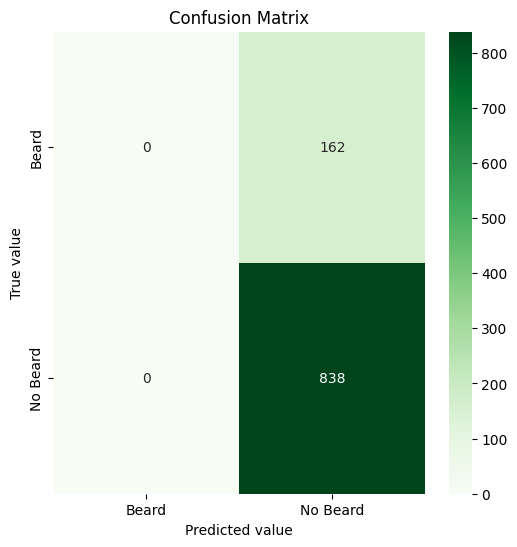

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 4ms/step
Accuracy: 0.834
Precision: 0.834
ROC-AUC Score: 0.5


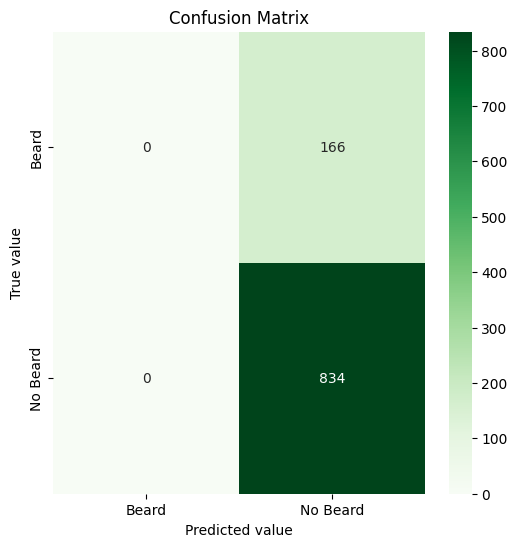

In [130]:
print_cofusion_matrix(mlp_1_2)

In [34]:
mlp_1_2.save_weights("mlp_1_2.h5")

In [35]:
mlp_2.compile(**COMPILE_PARAMS)

mlp_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 27648)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                1382450   
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,385,051
Trainable params: 1,385,051
No

In [36]:
history_mlp_2_1 = mlp_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 26s 314ms/step - loss: 1.7704 - accuracy: 0.5934 - val_loss: 0.6939 - val_accuracy: 0.1594
Epoch 2/20
79/79 [==============================] - 24s 306ms/step - loss: 0.6845 - accuracy: 0.1734 - val_loss: 0.6933 - val_accuracy: 0.1625
Epoch 3/20
79/79 [==============================] - 25s 312ms/step - loss: 0.7047 - accuracy: 0.7891 - val_loss: 0.6912 - val_accuracy: 0.8281
Epoch 4/20
79/79 [==============================] - 23s 287ms/step - loss: 0.6896 - accuracy: 0.8359 - val_loss: 0.6888 - val_accuracy: 0.8375
Epoch 5/20
79/79 [==============================] - 25s 308ms/step - loss: 0.6609 - accuracy: 0.8531 - val_loss: 0.6846 - val_accuracy: 0.8313
Epoch 6/20
79/79 [==============================] - 24s 298ms/step - loss: 0.7003 - accuracy: 0.8301 - val_loss: 0.6862 - val_accuracy: 0.8188
Epoch 7/20
79/79 [==============================] - 22s 276ms/step - loss: 0.6982 - accuracy: 0.8313 - val_loss: 0.6887 - val_accuracy: 0.8500

In [37]:
#set_model_best_weight(history_mlp_2_1, mlp_2)

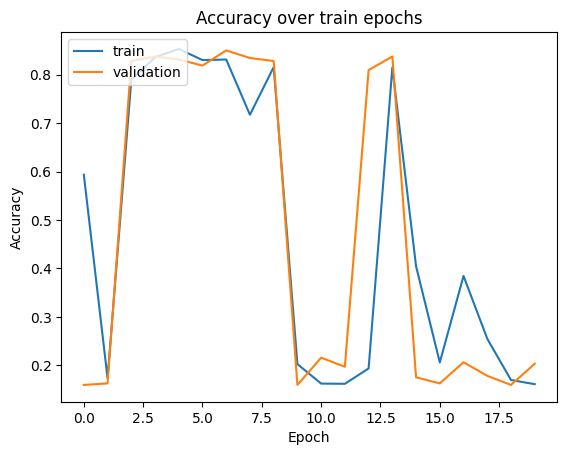

In [38]:
learning_curve(history_mlp_2_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.836
Precision: 0.836
ROC-AUC Score: 0.5


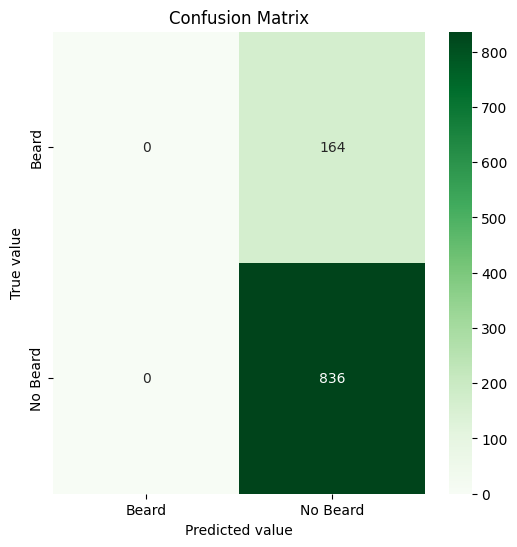

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.823
Precision: 0.823
ROC-AUC Score: 0.5


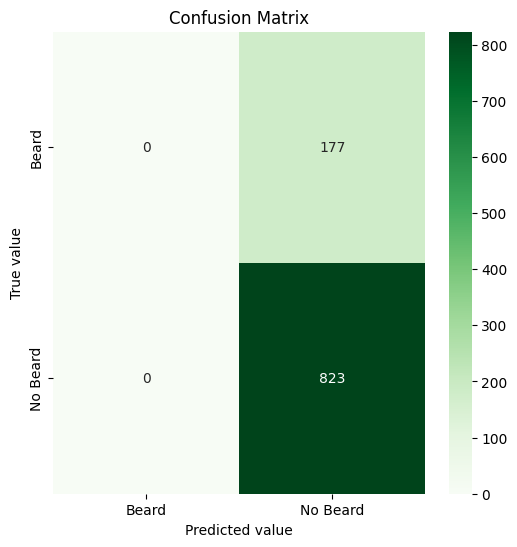

In [131]:
print_cofusion_matrix(mlp_2)

In [40]:
mlp_2.save_weights("mlp_2_1.h5")

In [41]:
mlp_2.compile(**COMPILE_PARAMS)

mlp_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 27648)             0         
                                                                 
 dense_4 (Dense)             (None, 50)                1382450   
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,385,051
Trainable params: 1,385,051
No

In [42]:
history_mlp_2_2 = mlp_2.fit(
    train,
    epochs=40,
    **FIT_PARAMS
)

Epoch 1/40
79/79 [==============================] - 20s 240ms/step - loss: 0.6877 - accuracy: 0.2520 - val_loss: 0.6944 - val_accuracy: 0.1406
Epoch 2/40
79/79 [==============================] - 19s 233ms/step - loss: 0.7000 - accuracy: 0.2484 - val_loss: 0.6959 - val_accuracy: 0.1844
Epoch 3/40
79/79 [==============================] - 18s 226ms/step - loss: 0.6898 - accuracy: 0.4035 - val_loss: 0.6931 - val_accuracy: 0.8250
Epoch 4/40
79/79 [==============================] - 19s 235ms/step - loss: 0.6885 - accuracy: 0.4973 - val_loss: 0.6924 - val_accuracy: 0.8219
Epoch 5/40
79/79 [==============================] - 18s 233ms/step - loss: 0.6823 - accuracy: 0.6684 - val_loss: 0.6894 - val_accuracy: 0.8594
Epoch 6/40
79/79 [==============================] - 18s 223ms/step - loss: 0.6675 - accuracy: 0.8492 - val_loss: 0.6829 - val_accuracy: 0.8219
Epoch 7/40
79/79 [==============================] - 18s 231ms/step - loss: 0.6936 - accuracy: 0.8340 - val_loss: 0.6831 - val_accuracy: 0.8313

In [43]:
#set_model_best_weight(history_mlp_2_2, mlp_2)

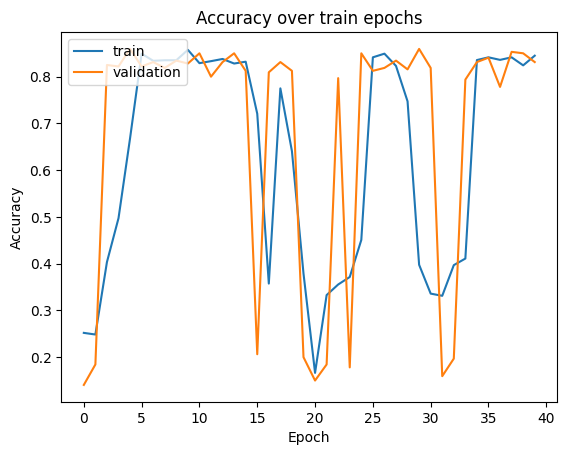

In [44]:
learning_curve(history_mlp_2_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.844
Precision: 0.844
ROC-AUC Score: 0.5


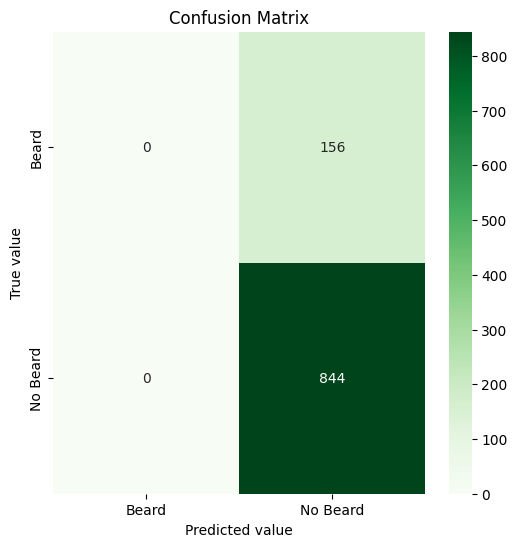

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.845
Precision: 0.845
ROC-AUC Score: 0.5


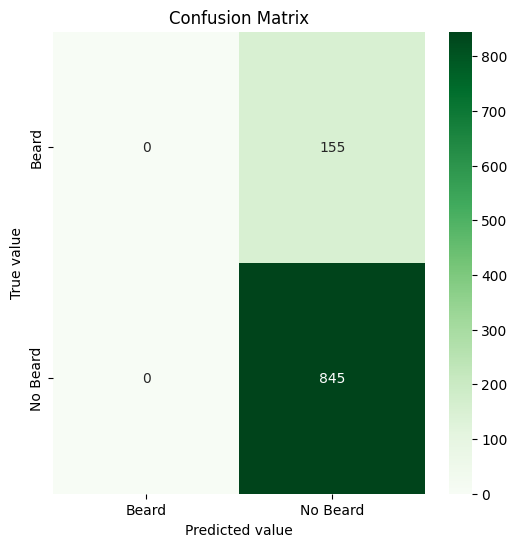

In [132]:
print_cofusion_matrix(mlp_2)

In [46]:
mlp_2.save_weights("mlp_2_2.h5")

In [47]:
mlp_3.compile(**COMPILE_PARAMS)

mlp_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 27648)             0         
                                                                 
 dense_7 (Dense)             (None, 60)                1658940   
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 dense_8 (Dense)             (None, 40)                2440      
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                820       
                                                                 
 dropout_6 (Dropout)         (None, 20)               

In [48]:
history_mlp_3 = mlp_3.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 12s 138ms/step - loss: 1.2224 - accuracy: 0.3562 - val_loss: 0.6975 - val_accuracy: 0.1594
Epoch 2/15
79/79 [==============================] - 11s 141ms/step - loss: 0.6622 - accuracy: 0.4660 - val_loss: 0.6902 - val_accuracy: 0.8438
Epoch 3/15
79/79 [==============================] - 11s 144ms/step - loss: 0.6856 - accuracy: 0.8387 - val_loss: 0.6891 - val_accuracy: 0.8406
Epoch 4/15
79/79 [==============================] - 11s 136ms/step - loss: 0.6929 - accuracy: 0.8340 - val_loss: 0.6894 - val_accuracy: 0.8531
Epoch 5/15
79/79 [==============================] - 10s 127ms/step - loss: 0.6736 - accuracy: 0.8457 - val_loss: 0.6873 - val_accuracy: 0.7500
Epoch 6/15
79/79 [==============================] - 10s 123ms/step - loss: 0.6802 - accuracy: 0.8418 - val_loss: 0.6850 - val_accuracy: 0.8031
Epoch 7/15
79/79 [==============================] - 10s 128ms/step - loss: 0.6842 - accuracy: 0.8395 - val_loss: 0.6840 - val_accuracy: 0.7969

In [49]:
#set_model_best_weight(history_mlp_3, mlp_3)

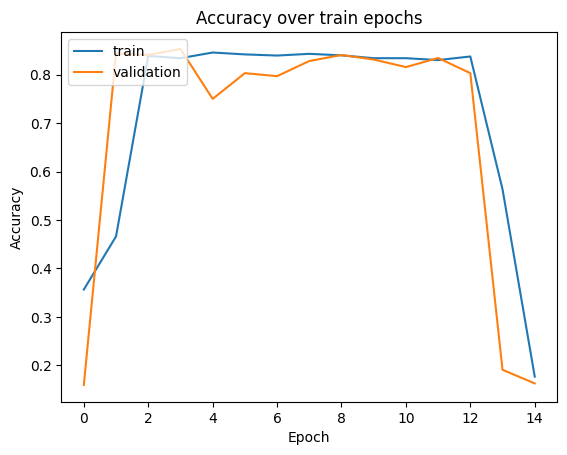

In [50]:
learning_curve(history_mlp_3)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.187
Precision: 0.0
ROC-AUC Score: 0.5


D:\HDD_Documents\Universidad\En_curso\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


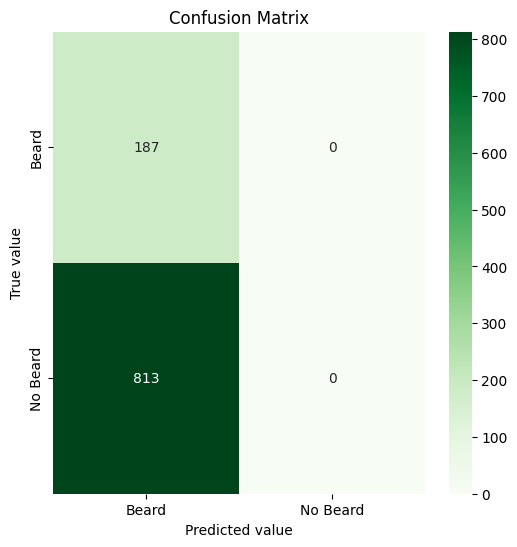

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 3ms/step
Accuracy: 0.181
Precision: 0.0
ROC-AUC Score: 0.5


D:\HDD_Documents\Universidad\En_curso\MachineLearning\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


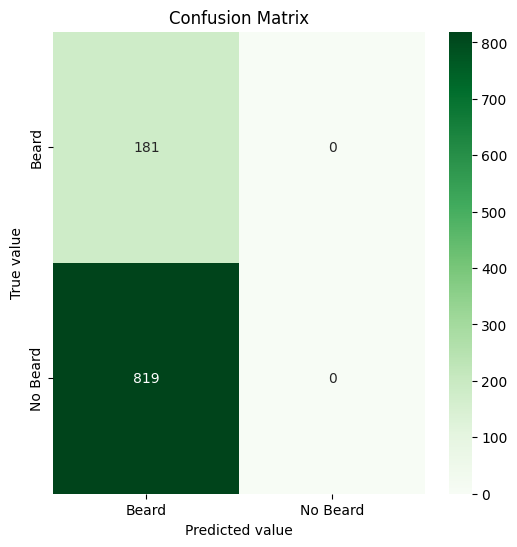

In [133]:
print_cofusion_matrix(mlp_3)

In [52]:
mlp_3.save_weights("mlp_3.h5")

In [53]:
mlp_4.compile(**COMPILE_PARAMS)

mlp_4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 27648)             0         
                                                                 
 dense_11 (Dense)            (None, 20)                552980    
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dropout_8 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dropout_9 (Dropout)         (None, 20)               

In [54]:
history_mlp_4 = mlp_4.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 9s 95ms/step - loss: 0.7739 - accuracy: 0.2801 - val_loss: 0.6975 - val_accuracy: 0.1719
Epoch 2/20
79/79 [==============================] - 9s 111ms/step - loss: 0.7185 - accuracy: 0.2203 - val_loss: 0.7110 - val_accuracy: 0.1844
Epoch 3/20
79/79 [==============================] - 9s 111ms/step - loss: 0.7009 - accuracy: 0.1707 - val_loss: 0.7036 - val_accuracy: 0.1969
Epoch 4/20
79/79 [==============================] - 9s 118ms/step - loss: 0.7001 - accuracy: 0.1875 - val_loss: 0.7051 - val_accuracy: 0.1937
Epoch 5/20
79/79 [==============================] - 8s 105ms/step - loss: 0.7054 - accuracy: 0.2000 - val_loss: 0.7029 - val_accuracy: 0.1656
Epoch 6/20
79/79 [==============================] - 8s 102ms/step - loss: 0.6854 - accuracy: 0.2047 - val_loss: 0.6936 - val_accuracy: 0.1813
Epoch 7/20
79/79 [==============================] - 9s 107ms/step - loss: 0.6936 - accuracy: 0.2055 - val_loss: 0.6949 - val_accuracy: 0.1594
Epoch 8

In [55]:
#set_model_best_weight(history_mlp_4, mlp_4)

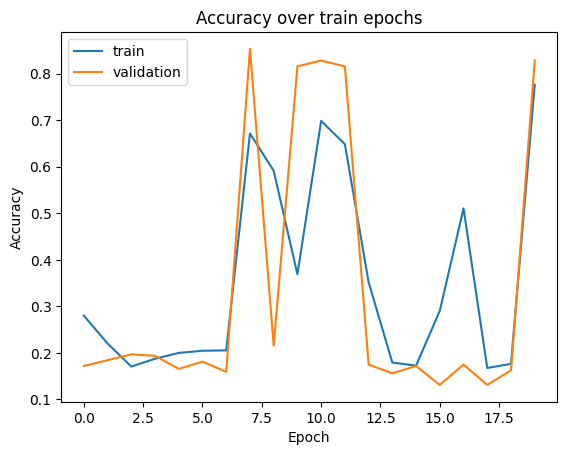

In [56]:
learning_curve(history_mlp_4)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 2ms/step
Accuracy: 0.826
Precision: 0.826
ROC-AUC Score: 0.5


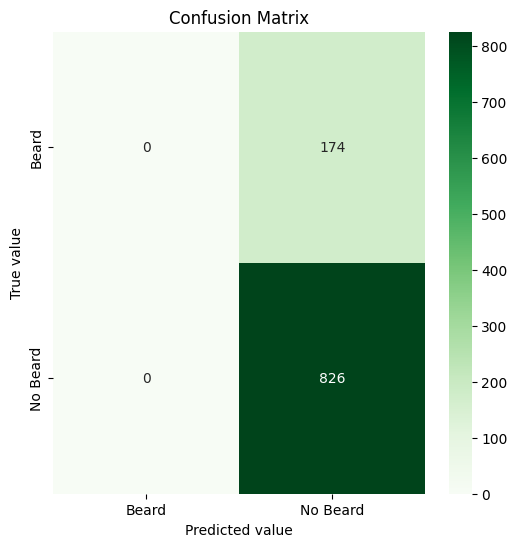

######################### validation #########################
Samples: 1000
32/32 [==============================] - 0s 2ms/step
Accuracy: 0.801
Precision: 0.801
ROC-AUC Score: 0.5


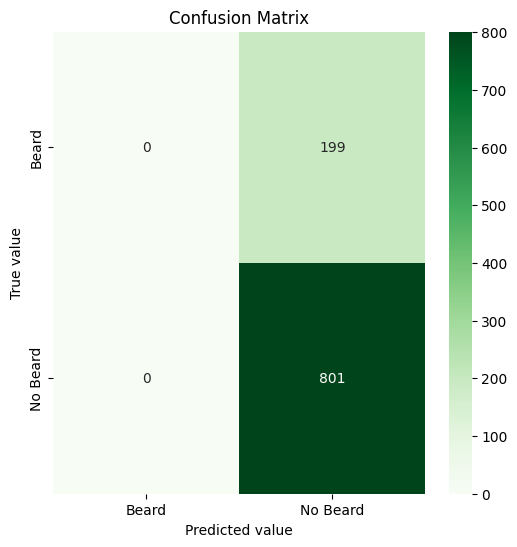

In [134]:
print_cofusion_matrix(mlp_4)

In [58]:
mlp_4.save_weights("mlp_4.h5")

## Convolutional Neural Networks

Planteamos distintas arquitecturas y variamos cantidad de épocas para ir comparando las diferencias entre los modelos.

Para no repetirlo, todos los modelos tienen una capa de salida que consta de una única neurona (ya que determina si no tiene barba o si sí tiene), con función de activación Sigmoid.

Para las redes neuronales convolucionales fuimos variando entre distintas cantidades de filtros, con distintos tamaños del kernel y distintos tamaños en el max pooling.

#### CNN 1_1 ####
__Arquitectura:__

_Capas:_
* 1 convolucional de 16 filtros. Tamaño de kernel 5. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 max pooling de tamaño 4.
* 1 densa de 100 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20

#### CNN 1_2 ####
__Arquitectura:__

_Capas:_
* 1 convolucional de 32 filtros. Tamaño de kernel 5. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 max pooling de tamaño 4.
* 1 densa de 100 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 15

Entrenamos estos dos modelos para ver la diferencia entre la cantidad de filtros. En el primer caso usamos 16 y en el segundo 32 filtros.
Vimos que las métricas de accuracy y ROC-AUC Score son muy similares, y en la matriz de confusión podemos ver que ambas clasifican muy bien los casos que no tienen barba. En los dos modelos vemos que la mayoría de errores se da en los casos que clasifica un rostro como que sí tiene barba cuando en realidad no tiene.
No notamos diferencia significativa con este cambio en la cantidad de filtros.

#### CNN 2_1 ####
__Arquitectura:__

_Capas:_
* 1 convolucional de 8 filtros. Tamaño de kernel 3. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 convolucional de 8 filtros. Tamaño de kernel 3. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 convolucional de 8 filtros. Tamaño de kernel 3. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 max pooling de tamaño 3.
* 1 densa de 100 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20

#### CNN 2_2 ####
__Arquitectura:__

_Capas:_
* 1 convolucional de 8 filtros. Tamaño de kernel 7. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 convolucional de 8 filtros. Tamaño de kernel 7. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 convolucional de 8 filtros. Tamaño de kernel 7. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 max pooling de tamaño 3.
* 1 densa de 100 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20

La idea principal de plantear estos modelos similares, fue ver la variación en las métricas y en la matriz de confusión que puede generar el tamaño del kernel.
En ambos casos, las métricas de accuracy y ROC-AUC Score no diferen mucho, pero son ligeramente mejores en el CNN_2_2.
Podemos ver en las matrices de confusión que ambos modelos detectan muy bien los casos en que el rostro no tiene barba, pero no es tan bueno identificando los casos que sí tienen barba.
En definitiva, vemos que el modelo CNN_2_2 es un buen candidato para elegirlo como modelo definitivo.

#### CNN 3 ####
__Arquitectura:__

_Capas:_
* 1 convolucional de 6 filtros. Tamaño de kernel 5. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 max pooling de tamaño 2.
* 1 convolucional de 16 filtros. Tamaño de kernel 5. Strides 1. Activación: ReLU
* 1 max pooling de tamaño 2.
* 1 Dropout del 0.25
* 1 densa de 128 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 densa de 64 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 densa de 32 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20

De los modelos de redes neuronales convolucionales planteados, este fue el que mejores resultados nos dió.
Viendo el análisis de la matriz de confusión, vemos que es el que mejor diferencia entre las clases. Lo hace de muy buena manera en los casos de que el rostro no tiene barba, y vemos que es menos preciso en los casos que el rostro sí tiene barba, pero este último caso lo clasifica de mejor manera que los modelos anteriores.
Este modelo obtuve un accuracy de 0.87 y un ROC-AUC Score de 0.876.

Para concluir con las redes neuronales convolucionales, notamos que estas se entrenan más rápido que los MLP y de primeras devuelven resultados bastantes aceptables, y no se dan los casos en los que solo clasifica por una única clase. Podemos comprobar lo que vimos en la teoría, que son un tipo de redes neuronales que funcionan bastante bien con problemas de imágenes.

In [60]:
# CNN
cnn_1_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_1_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=32, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_2_1 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_2_2 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(3, 3)),
    
    Flatten(),
    
    Dense(100, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

cnn_3 = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=6, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

In [61]:
cnn_1_1.compile(**COMPILE_PARAMS)

cnn_1_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 16)        1216      
                                                                 
 dropout_14 (Dropout)        (None, 92, 92, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 16)       0         
 )                                                               
                                                                 
 flatten_5 (Flatten)         (None, 8464)              0         
                                                                 
 dense_19 (Dense)            (None, 100)               846500    
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                      

In [62]:
history_cnn_1_1 = cnn_1_1.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 10s 110ms/step - loss: 0.7821 - accuracy: 0.4512 - val_loss: 0.6654 - val_accuracy: 0.6000
Epoch 2/20
79/79 [==============================] - 8s 100ms/step - loss: 0.5971 - accuracy: 0.6641 - val_loss: 0.5148 - val_accuracy: 0.7563
Epoch 3/20
79/79 [==============================] - 9s 108ms/step - loss: 0.5244 - accuracy: 0.7164 - val_loss: 0.5323 - val_accuracy: 0.7281
Epoch 4/20
79/79 [==============================] - 8s 101ms/step - loss: 0.4748 - accuracy: 0.7480 - val_loss: 0.5279 - val_accuracy: 0.7344
Epoch 5/20
79/79 [==============================] - 8s 106ms/step - loss: 0.4399 - accuracy: 0.7641 - val_loss: 0.4047 - val_accuracy: 0.7969
Epoch 6/20
79/79 [==============================] - 8s 99ms/step - loss: 0.4209 - accuracy: 0.7848 - val_loss: 0.4265 - val_accuracy: 0.7812
Epoch 7/20
79/79 [==============================] - 9s 109ms/step - loss: 0.4011 - accuracy: 0.8012 - val_loss: 0.4652 - val_accuracy: 0.7563
Epoch 

In [63]:
#set_model_best_weight(history_cnn_1_1, cnn_1_1)

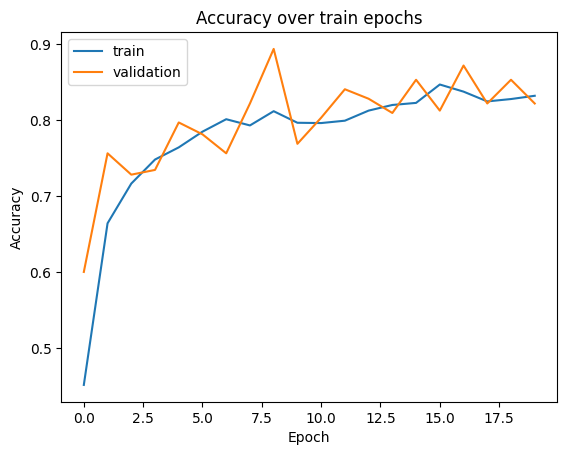

In [64]:
learning_curve(history_cnn_1_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 0s 14ms/step
Accuracy: 0.812
Precision: 0.9789473684210527
ROC-AUC Score: 0.8545454545454546


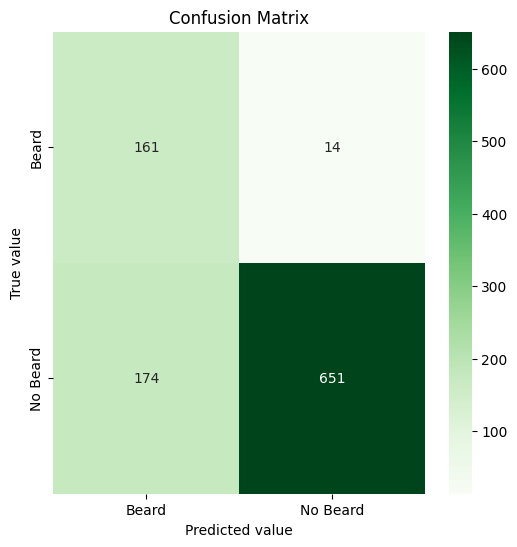

######################### validation #########################
Samples: 867
28/28 [==============================] - 0s 12ms/step
Accuracy: 0.8154555940023068
Precision: 0.9749582637729549
ROC-AUC Score: 0.8462008707580366


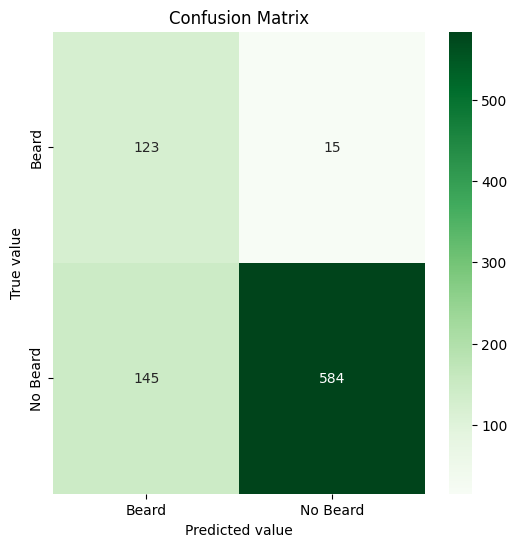

In [135]:
print_cofusion_matrix(cnn_1_1)

In [66]:
cnn_1_1.save_weights("cnn_1_1.h5")

In [67]:
cnn_1_2.compile(**COMPILE_PARAMS)

cnn_1_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        2432      
                                                                 
 dropout_16 (Dropout)        (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 16928)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               1692900   
                                                                 
 dropout_17 (Dropout)        (None, 100)               0         
                                                      

In [68]:
history_cnn_1_2 = cnn_1_2.fit(
    train,
    epochs=15,
    **FIT_PARAMS
)

Epoch 1/15
79/79 [==============================] - 12s 142ms/step - loss: 0.7352 - accuracy: 0.5508 - val_loss: 0.6131 - val_accuracy: 0.7437
Epoch 2/15
79/79 [==============================] - 11s 134ms/step - loss: 0.5913 - accuracy: 0.6859 - val_loss: 0.6565 - val_accuracy: 0.6562
Epoch 3/15
79/79 [==============================] - 10s 127ms/step - loss: 0.5369 - accuracy: 0.7102 - val_loss: 0.4604 - val_accuracy: 0.8031
Epoch 4/15
79/79 [==============================] - 10s 130ms/step - loss: 0.4642 - accuracy: 0.7598 - val_loss: 0.4530 - val_accuracy: 0.8062
Epoch 5/15
79/79 [==============================] - 10s 128ms/step - loss: 0.4216 - accuracy: 0.7809 - val_loss: 0.3340 - val_accuracy: 0.8375
Epoch 6/15
79/79 [==============================] - 10s 126ms/step - loss: 0.4561 - accuracy: 0.7578 - val_loss: 0.3504 - val_accuracy: 0.8375
Epoch 7/15
79/79 [==============================] - 10s 127ms/step - loss: 0.4114 - accuracy: 0.7836 - val_loss: 0.3496 - val_accuracy: 0.8281

In [69]:
#set_model_best_weight(history_cnn_1_2, cnn_1_2)

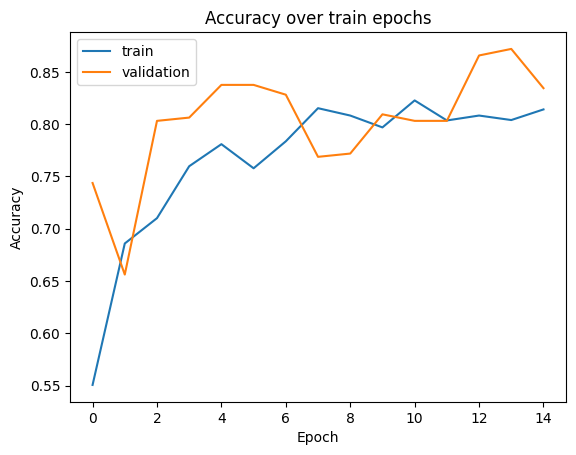

In [70]:
learning_curve(history_cnn_1_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 17ms/step
Accuracy: 0.829
Precision: 0.9782608695652174
ROC-AUC Score: 0.8617584858906714


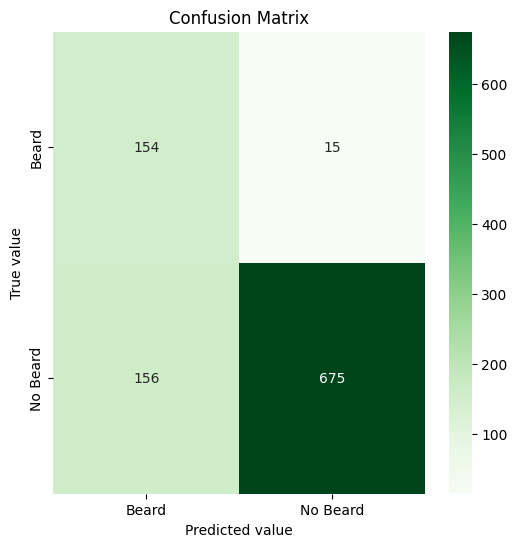

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 16ms/step
Accuracy: 0.826
Precision: 0.9747774480712166
ROC-AUC Score: 0.8578637288314708


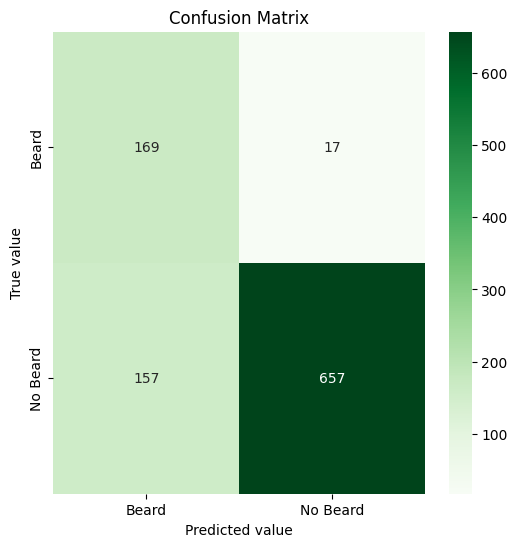

In [136]:
print_cofusion_matrix(cnn_1_2)

In [72]:
cnn_1_2.save_weights("cnn_1_2.h5")

In [73]:
cnn_2_1.compile(**COMPILE_PARAMS)

cnn_2_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 94, 94, 8)         224       
                                                                 
 dropout_18 (Dropout)        (None, 94, 94, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 92, 92, 8)         584       
                                                                 
 dropout_19 (Dropout)        (None, 92, 92, 8)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 8)         584       
                                                                 
 dropout_20 (Dropout)        (None, 90, 90, 8)         0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 8)       

In [74]:
history_cnn_2_1 = cnn_2_1.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 13s 151ms/step - loss: 0.8756 - accuracy: 0.5176 - val_loss: 0.6941 - val_accuracy: 0.2281
Epoch 2/20
79/79 [==============================] - 12s 149ms/step - loss: 0.6829 - accuracy: 0.6555 - val_loss: 0.6976 - val_accuracy: 0.2500
Epoch 3/20
79/79 [==============================] - 12s 151ms/step - loss: 0.6312 - accuracy: 0.6824 - val_loss: 0.6973 - val_accuracy: 0.3375
Epoch 4/20
79/79 [==============================] - 13s 169ms/step - loss: 0.6049 - accuracy: 0.6941 - val_loss: 0.6896 - val_accuracy: 0.4969
Epoch 5/20
79/79 [==============================] - 14s 170ms/step - loss: 0.5614 - accuracy: 0.7059 - val_loss: 0.6909 - val_accuracy: 0.5094
Epoch 6/20
79/79 [==============================] - 13s 163ms/step - loss: 0.6026 - accuracy: 0.6711 - val_loss: 0.7026 - val_accuracy: 0.4688
Epoch 7/20
79/79 [==============================] - 13s 165ms/step - loss: 0.5225 - accuracy: 0.7457 - val_loss: 0.7013 - val_accuracy: 0.5000

In [75]:
#set_model_best_weight(history_cnn_2_1, cnn_2_1)

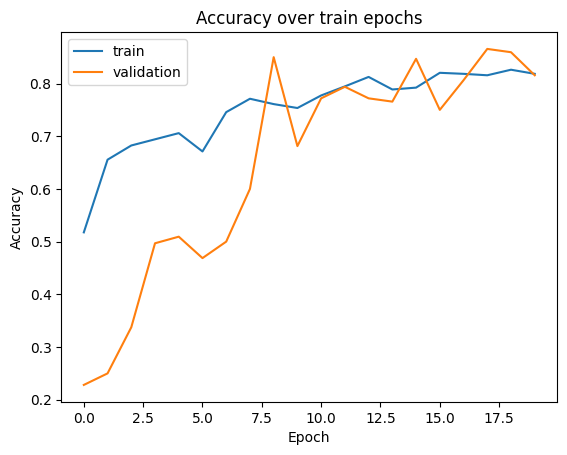

In [76]:
learning_curve(history_cnn_2_1)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 20ms/step
Accuracy: 0.797
Precision: 0.956140350877193
ROC-AUC Score: 0.808699876285201


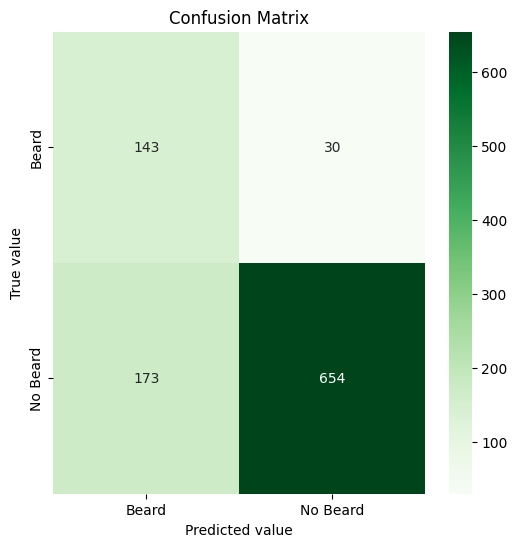

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 22ms/step
Accuracy: 0.84
Precision: 0.9659090909090909
ROC-AUC Score: 0.8514492753623188


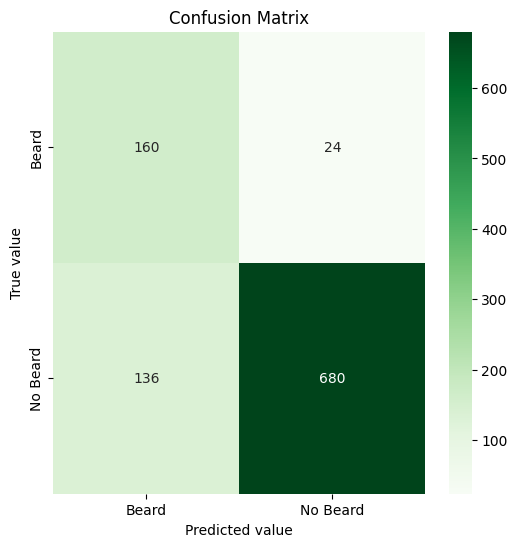

In [137]:
print_cofusion_matrix(cnn_2_1)

In [78]:
cnn_2_1.save_weights("cnn_2_1.h5")

In [79]:
cnn_2_2.compile(**COMPILE_PARAMS)

cnn_2_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 90, 90, 8)         1184      
                                                                 
 dropout_22 (Dropout)        (None, 90, 90, 8)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 84, 84, 8)         3144      
                                                                 
 dropout_23 (Dropout)        (None, 84, 84, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 8)         3144      
                                                                 
 dropout_24 (Dropout)        (None, 78, 78, 8)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 8)       

In [80]:
history_cnn_2_2 = cnn_2_2.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 29s 347ms/step - loss: 0.6844 - accuracy: 0.6027 - val_loss: 0.7027 - val_accuracy: 0.1656
Epoch 2/20
79/79 [==============================] - 27s 345ms/step - loss: 0.6672 - accuracy: 0.6160 - val_loss: 0.6746 - val_accuracy: 0.6469
Epoch 3/20
79/79 [==============================] - 28s 348ms/step - loss: 0.5789 - accuracy: 0.7102 - val_loss: 0.6208 - val_accuracy: 0.7500
Epoch 4/20
79/79 [==============================] - 28s 345ms/step - loss: 0.4928 - accuracy: 0.7652 - val_loss: 0.4699 - val_accuracy: 0.7969
Epoch 5/20
79/79 [==============================] - 28s 345ms/step - loss: 0.4353 - accuracy: 0.7941 - val_loss: 0.4201 - val_accuracy: 0.8281
Epoch 6/20
79/79 [==============================] - 27s 344ms/step - loss: 0.4121 - accuracy: 0.8133 - val_loss: 0.4599 - val_accuracy: 0.7563
Epoch 7/20
79/79 [==============================] - 28s 345ms/step - loss: 0.3860 - accuracy: 0.8195 - val_loss: 0.4177 - val_accuracy: 0.7937

In [81]:
#set_model_best_weight(history_cnn_2_2, cnn_2_2)

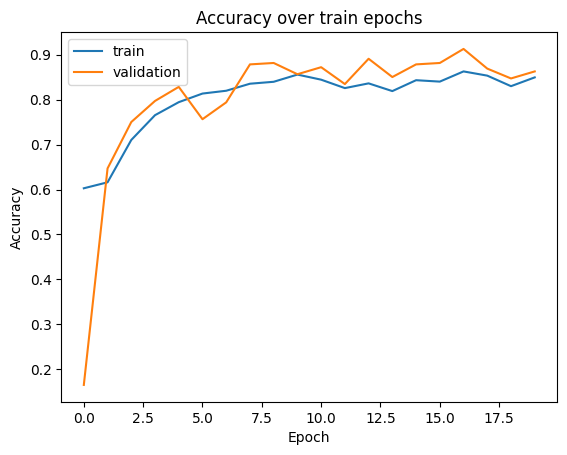

In [82]:
learning_curve(history_cnn_2_2)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 37ms/step
Accuracy: 0.858
Precision: 0.9735006973500697
ROC-AUC Score: 0.8720187263114202


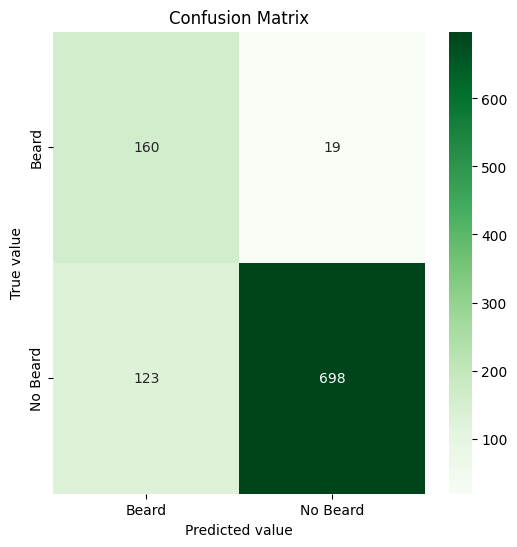

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 37ms/step
Accuracy: 0.86
Precision: 0.9695290858725761
ROC-AUC Score: 0.8674333001961363


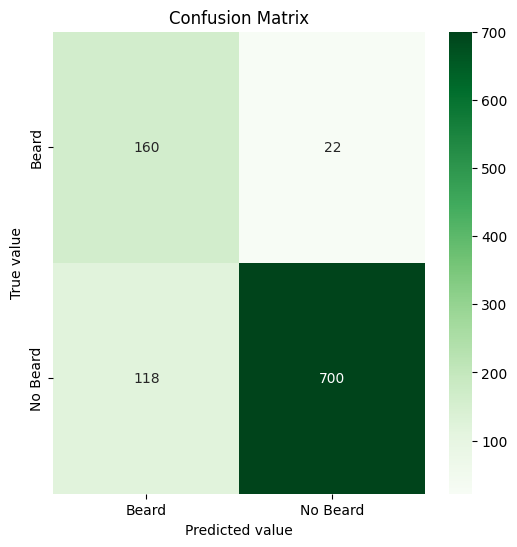

In [138]:
print_cofusion_matrix(cnn_2_2)

In [84]:
cnn_2_2.save_weights("cnn_2_2.h5")

In [146]:
cnn_3.compile(**COMPILE_PARAMS)

cnn_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 92, 92, 6)         456       
                                                                 
 dropout_26 (Dropout)        (None, 92, 92, 6)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 46, 46, 6)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 21, 16)       0         
 2D)                                                             
                                                                 
 dropout_27 (Dropout)        (None, 21, 21, 16)       

In [149]:
history_cnn_3 = cnn_3.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 8s 94ms/step - loss: 0.3380 - accuracy: 0.8195 - val_loss: 0.2804 - val_accuracy: 0.8344
Epoch 2/20
79/79 [==============================] - 7s 93ms/step - loss: 0.3328 - accuracy: 0.8230 - val_loss: 0.2773 - val_accuracy: 0.8531
Epoch 3/20
79/79 [==============================] - 8s 99ms/step - loss: 0.3264 - accuracy: 0.8449 - val_loss: 0.2604 - val_accuracy: 0.8625
Epoch 4/20
79/79 [==============================] - 8s 101ms/step - loss: 0.3581 - accuracy: 0.7989 - val_loss: 0.4619 - val_accuracy: 0.7219
Epoch 5/20
79/79 [==============================] - 8s 102ms/step - loss: 0.3219 - accuracy: 0.8227 - val_loss: 0.2719 - val_accuracy: 0.8938
Epoch 6/20
79/79 [==============================] - 8s 99ms/step - loss: 0.3560 - accuracy: 0.8289 - val_loss: 0.2953 - val_accuracy: 0.8781
Epoch 7/20
79/79 [==============================] - 8s 100ms/step - loss: 0.3334 - accuracy: 0.8445 - val_loss: 0.3178 - val_accuracy: 0.8250
Epoch 8/20

In [87]:
#set_model_best_weight(history_cnn_3, cnn_3)

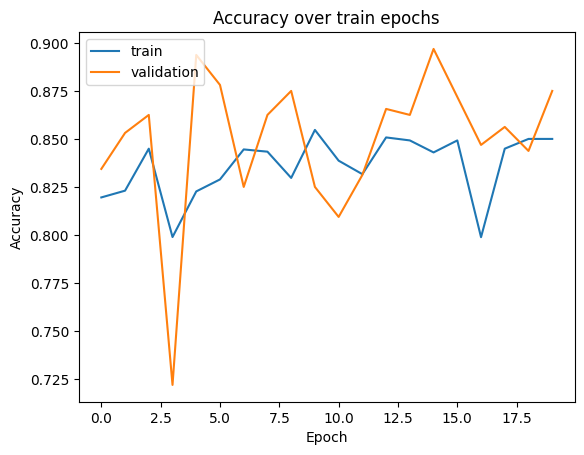

In [150]:
learning_curve(history_cnn_3)

######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 19ms/step
Accuracy: 0.866
Precision: 0.986130374479889
ROC-AUC Score: 0.8954454726909818


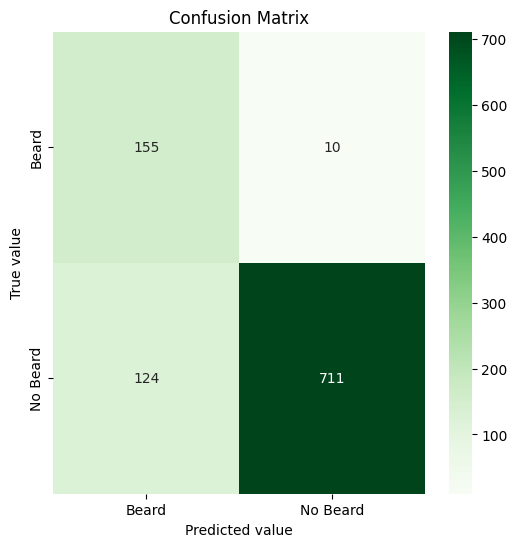

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 20ms/step
Accuracy: 0.87
Precision: 0.9727891156462585
ROC-AUC Score: 0.8761904761904762


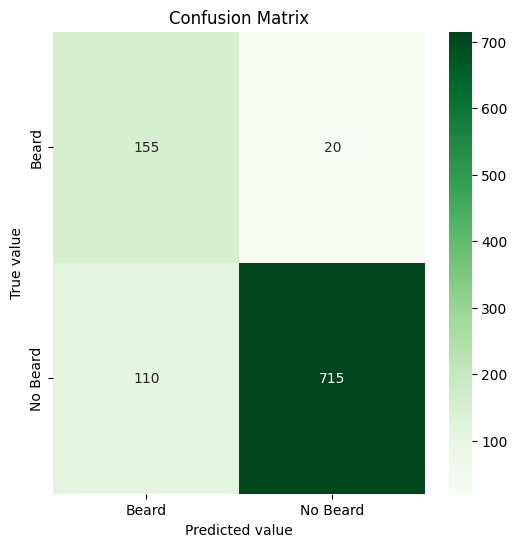

In [151]:
print_cofusion_matrix(cnn_3)

In [152]:
cnn_3.save_weights("cnn_3.h5")

## Pre-Trained Models
Utilizamo un modelo pre-entrenado para realizar transfer learning. Este fue obtenido de la librería de Keras.

### VGG16
Es un modelo de red neuronal de convolución (CNN) que admite 16 capas.

VGG16, como su nombre indica, es una red neuronal profunda de 16 capas. Por lo tanto, VGG16 es una red relativamente extensa con un total de 138 millones de parámetros. Sin embargo, la sencillez de la arquitectura VGGNet16 es su principal atractivo.
El modelo VGG16 puede lograr una precisión de prueba del 92,7 % en ImageNet, un conjunto de datos que contiene más de 14 millones de imágenes de entrenamiento en 1000 clases de objetos.

Planteamos un modelo que utiliza este modelo pre-entrenado y a las salidas de este luego le agremos dos capas densas, una de 512 y otra de 256 neuronas com función de activación ReLU.

Realizamos el entrenamiento de este modelo en 20 épocas, obteniendo un valor de accuracy de 0.78 y ROC-AUC Score de 0.84, valores menores a los obtenidos en modelos anteriores.
Podemos ver en la matriz de confusión, que clasifica de manera bastante correcta los casos de rostros sin barba, pero parece tener problemas con los casos de rostros que sí tienen barba, incluso la mayoría de veces esta clasificación la hace mal.

Creemos que aplicando una distinta arquitectura y adaptando las últimas capas de VGG16 a nuestro caso de uso, se podrían obtener mejores resultados.

In [92]:
### VGG16
vgg16_model = VGG16(input_shape=(SIZE,SIZE,3), include_top=False)
vgg16_model.trainable = False

pre_trained_model_vgg16 = Sequential([
    vgg16_model,

    Flatten(),

    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid'),
])

In [93]:
pre_trained_model_vgg16.compile(**COMPILE_PARAMS)

pre_trained_model_vgg16.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 4608)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               2359808   
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 17,206,081
Trainable params: 2,491,393


In [94]:
history_pre_trained_model_vgg16 = pre_trained_model_vgg16.fit(
    train,
    epochs=20,
    **FIT_PARAMS
)

Epoch 1/20
79/79 [==============================] - 46s 566ms/step - loss: 0.5690 - accuracy: 0.6859 - val_loss: 0.3695 - val_accuracy: 0.8219
Epoch 2/20
79/79 [==============================] - 48s 599ms/step - loss: 0.4945 - accuracy: 0.7258 - val_loss: 0.3750 - val_accuracy: 0.8000
Epoch 3/20
79/79 [==============================] - 46s 581ms/step - loss: 0.4614 - accuracy: 0.7395 - val_loss: 0.4621 - val_accuracy: 0.7375
Epoch 4/20
79/79 [==============================] - 46s 585ms/step - loss: 0.4817 - accuracy: 0.7281 - val_loss: 0.4804 - val_accuracy: 0.7344
Epoch 5/20
79/79 [==============================] - 46s 582ms/step - loss: 0.4292 - accuracy: 0.7680 - val_loss: 0.5131 - val_accuracy: 0.7188
Epoch 6/20
79/79 [==============================] - 47s 589ms/step - loss: 0.4545 - accuracy: 0.7375 - val_loss: 0.4871 - val_accuracy: 0.7250
Epoch 7/20
79/79 [==============================] - 47s 597ms/step - loss: 0.4316 - accuracy: 0.7551 - val_loss: 0.5381 - val_accuracy: 0.6938

In [95]:
#set_model_best_weight(history_pre_trained_model_vgg16, pre_trained_model_vgg16)

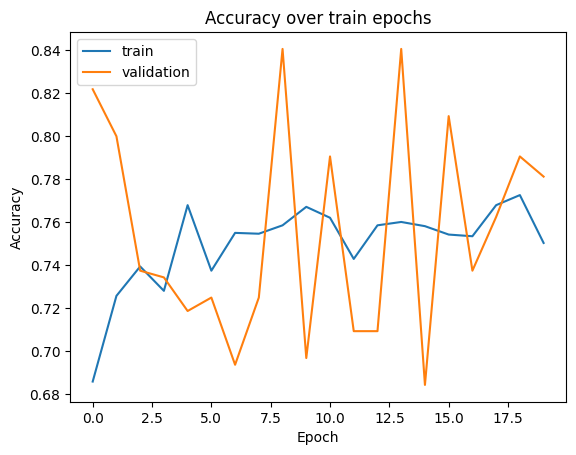

In [96]:
learning_curve(history_pre_trained_model_vgg16)

######################### train #########################
Samples: 1000
32/32 [==============================] - 16s 492ms/step
Accuracy: 0.746
Precision: 0.9730639730639731
ROC-AUC Score: 0.8106884057971016


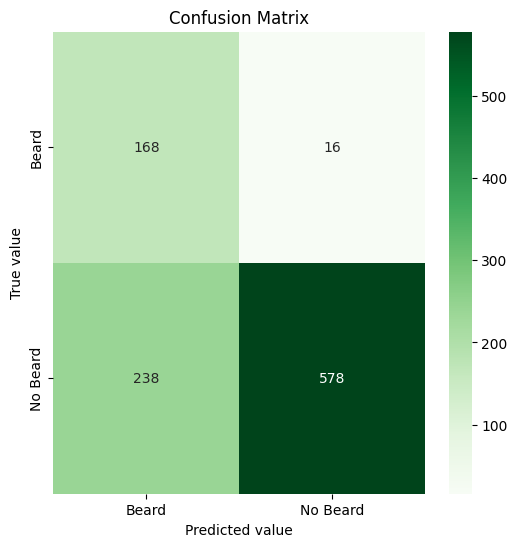

######################### validation #########################
Samples: 1000
32/32 [==============================] - 14s 441ms/step
Accuracy: 0.788
Precision: 0.9796875
ROC-AUC Score: 0.8421836297347695


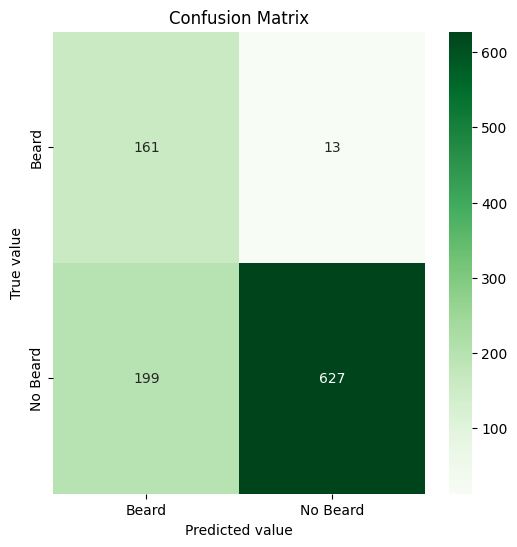

In [140]:
print_cofusion_matrix(pre_trained_model_vgg16)

In [98]:
pre_trained_model_vgg16.save_weights("pre_trained_model_vgg16.h5")

## Data Augmentation

### Modelo Seleccionado: "CNN 3"

__Descripcion del modelo__
_Capas:_
* 1 convolucional de 6 filtros. Tamaño de kernel 5. Strides 1. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 max pooling de tamaño 2.
* 1 convolucional de 16 filtros. Tamaño de kernel 5. Strides 1. Activación: ReLU
* 1 max pooling de tamaño 2.
* 1 Dropout del 0.25
* 1 densa de 128 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 densa de 64 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU
* 1 densa de 32 neuronas. Aplica dropout del 0.25 a la salida. Activación: ReLU

_Épocas:_ 20

Este modelo fue elegido ya que fué el que nos arrojó mejores valores en las métricas de accuracy y ROC-AUC Score, además vimos en su matriz de confusión que es uno de los que mejor diferencian entre las clases.
También nos pareció que tiene una arquitectura interesante.


### Configuración del generador
Basándonos en la información encontrada en la documentación de la biblioteca Keras sobre el ImageDataGenerator, decidimos aplicar las siguientes técnicas de aumentación de datos:

__rotation_range:__ rango en grados para realizar rotaciones aleatorias.

__brightness_range:__ rango en el que se modificará el brillo de la imagen de manera aleatoria.

__width_shift_range:__ rango en que se moverá la imagen hacia los lados. Un valor de 0.25 indica que se moverá entre rangos de -24px y 24px (ya que usamos imágenes de 96px).

__height_shift_range:__ lo mismo que lo anterior pero mueve la imágen hacia arriba o abajo.

__horizontal_flip:__ espeja algunas imágenes aleatorias.

__zoom_range:__ aplica zoom aleatorio. En este caso, entre -15% y 15%.

__fill_mode:__ rellena las partes de las imágenes que se pierden al aplicar las técnicas anteriores. Por ejemplo, si se aplica un zoom de -10%, quedarán partes en las imágenes en negro. Al usar el modo 'nearest', rellena estos píxeles con los colores de los píxeles cercanos.

In [14]:
datagen_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=(0.5, 1.5),
    width_shift_range=0.25,
    height_shift_range=0.25,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode='nearest',
)

train_augmentation = datagen_augmentation.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS)

validation_augmentation = datagen_augmentation.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS)

test_augmentation = datagen_augmentation.flow_from_dataframe(dataframe=df_test, **GENERATOR_PARAMS)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.


#### Ejemplos de imágenes modificadas
A continuación se pueden ver algunas imágenes que fueron modificadas con lo definido anteriormente.
Se puede observar que a algunas se les modificó el brillo, otras fueron movidas hacia arriba y costados, etc.

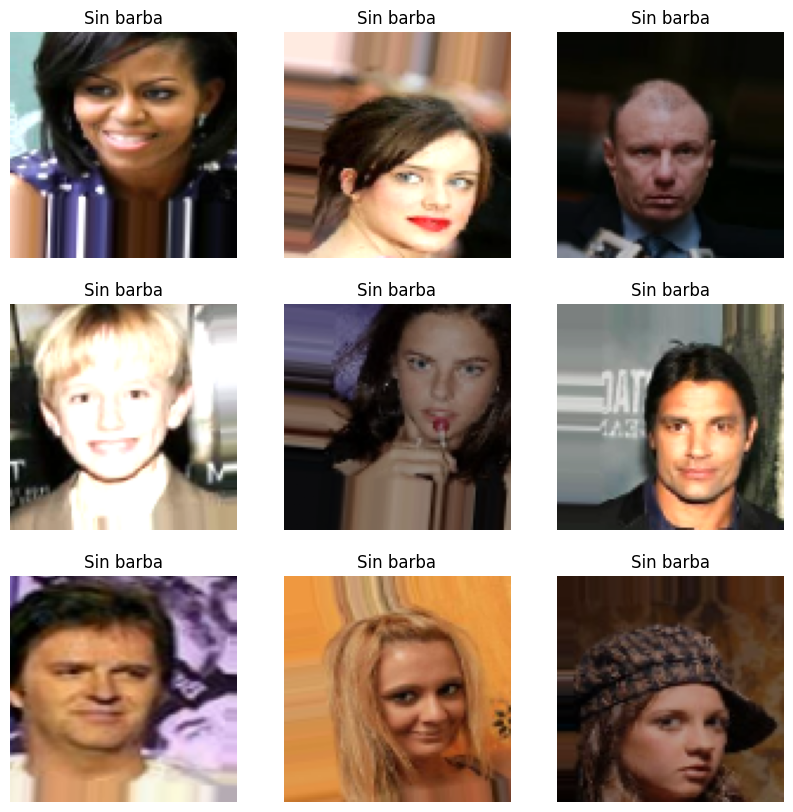

In [15]:
sample_images(test_augmentation)

In [153]:
# Reentrenamos el modelo seleccionado con el set de datos con data augmentation.
chosen_model = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=6, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

chosen_model.compile(**COMPILE_PARAMS)

history_chosen_model = chosen_model.fit(
    train_augmentation,
    epochs=20,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_augmentation)/BATCH_SIZE,
    validation_steps=len(validation_augmentation)/BATCH_SIZE,
    validation_data=validation_augmentation,
    callbacks=[OurCustomCallback()],
    class_weight = class_weights,
)

Epoch 1/20
79/79 [==============================] - 13s 155ms/step - loss: 0.7036 - accuracy: 0.4902 - val_loss: 0.6851 - val_accuracy: 0.7625
Epoch 2/20
79/79 [==============================] - 12s 155ms/step - loss: 0.7017 - accuracy: 0.4492 - val_loss: 0.6892 - val_accuracy: 0.5594
Epoch 3/20
79/79 [==============================] - 12s 154ms/step - loss: 0.6872 - accuracy: 0.4668 - val_loss: 0.6734 - val_accuracy: 0.7594
Epoch 4/20
79/79 [==============================] - 13s 158ms/step - loss: 0.6920 - accuracy: 0.4918 - val_loss: 0.6689 - val_accuracy: 0.7656
Epoch 5/20
79/79 [==============================] - 11s 141ms/step - loss: 0.7090 - accuracy: 0.5238 - val_loss: 0.7542 - val_accuracy: 0.2656
Epoch 6/20
79/79 [==============================] - 11s 143ms/step - loss: 0.6834 - accuracy: 0.6082 - val_loss: 0.6055 - val_accuracy: 0.7219
Epoch 7/20
79/79 [==============================] - 11s 144ms/step - loss: 0.6880 - accuracy: 0.5586 - val_loss: 0.6459 - val_accuracy: 0.7656

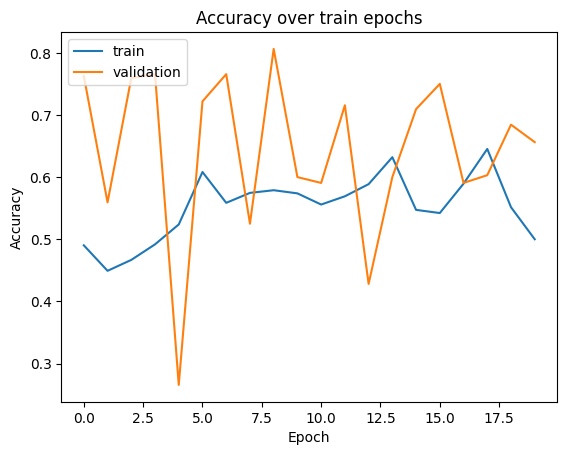

In [154]:
learning_curve(history_chosen_model)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 16ms/step
Accuracy: 0.598
Precision: 0.9474747474747475
ROC-AUC Score: 0.6936438251574728


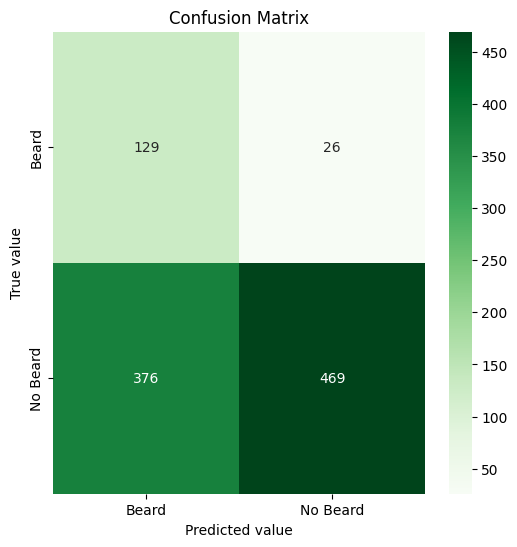

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 16ms/step
Accuracy: 0.619
Precision: 0.9187145557655955
ROC-AUC Score: 0.6727438217122682


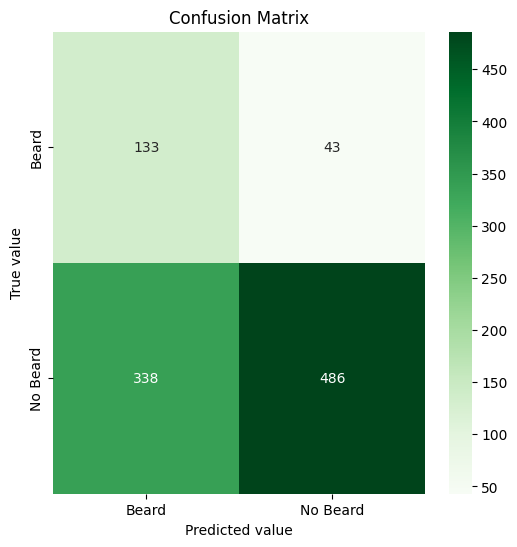

In [157]:
datasets_augmentation = (
    ('train_augmentation', datagen_augmentation.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS, batch_size=1000)),
    ('validation_augmentation', datagen_augmentation.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS, batch_size=1000)),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))

    predictions = np.round(chosen_model.predict(batch_images)).flatten()
    labels = batch_labels

    print('Accuracy:', accuracy_score(labels, predictions))
    print('Precision:', precision_score(labels, predictions))
    print('ROC-AUC Score:', roc_auc_score(labels,predictions))

    VALORES = "Beard", "No Beard"

    plt.figure(figsize=(6,6))

    sns.heatmap(confusion_matrix(labels, predictions), annot=True, cmap='Greens', xticklabels=VALORES, yticklabels=VALORES, fmt='g')
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.title('Confusion Matrix')
    plt.show()

In [158]:
chosen_model.save_weights("chosen_model.h5")

In [159]:
chosen_model_more_epochs = Sequential([
    Convolution2D(input_shape=(SIZE,SIZE,3), filters=6, kernel_size=(5, 5), strides=1, activation='relu'),
    Dropout(0.25),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=16, kernel_size=(5, 5), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

chosen_model_more_epochs.compile(**COMPILE_PARAMS)

history_chosen_model_more_epochs = chosen_model_more_epochs.fit(
    train_augmentation,
    epochs=50,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_augmentation)/BATCH_SIZE,
    validation_steps=len(validation_augmentation)/BATCH_SIZE,
    validation_data=validation_augmentation,
    callbacks=[OurCustomCallback()],
    class_weight = class_weights,
)

Epoch 1/50
79/79 [==============================] - 13s 154ms/step - loss: 0.7087 - accuracy: 0.2633 - val_loss: 0.6969 - val_accuracy: 0.1875
Epoch 2/50
79/79 [==============================] - 11s 140ms/step - loss: 0.6570 - accuracy: 0.6734 - val_loss: 0.6711 - val_accuracy: 0.8562
Epoch 3/50
79/79 [==============================] - 11s 141ms/step - loss: 0.6997 - accuracy: 0.6098 - val_loss: 0.6917 - val_accuracy: 0.6625
Epoch 4/50
79/79 [==============================] - 11s 140ms/step - loss: 0.6990 - accuracy: 0.4219 - val_loss: 0.6919 - val_accuracy: 0.6219
Epoch 5/50
79/79 [==============================] - 11s 143ms/step - loss: 0.7148 - accuracy: 0.5973 - val_loss: 0.6875 - val_accuracy: 0.7781
Epoch 6/50
79/79 [==============================] - 13s 158ms/step - loss: 0.6968 - accuracy: 0.6039 - val_loss: 0.6918 - val_accuracy: 0.5656
Epoch 7/50
79/79 [==============================] - 12s 146ms/step - loss: 0.6770 - accuracy: 0.5848 - val_loss: 0.6629 - val_accuracy: 0.8156

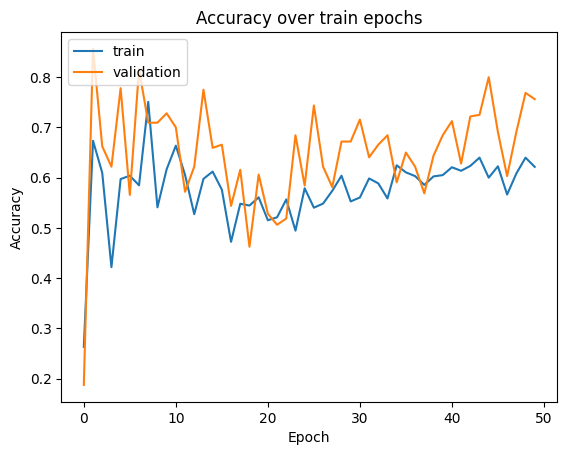

In [160]:
learning_curve(history_chosen_model_more_epochs)

Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
######################### train #########################
Samples: 1000
32/32 [==============================] - 1s 18ms/step
Accuracy: 0.745
Precision: 0.9228529839883551
ROC-AUC Score: 0.7176012370171548


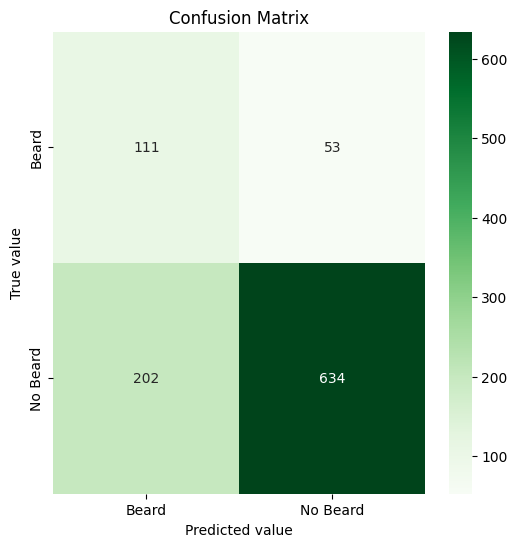

######################### validation #########################
Samples: 1000
32/32 [==============================] - 1s 18ms/step
Accuracy: 0.746
Precision: 0.899856938483548
ROC-AUC Score: 0.6996730929876145


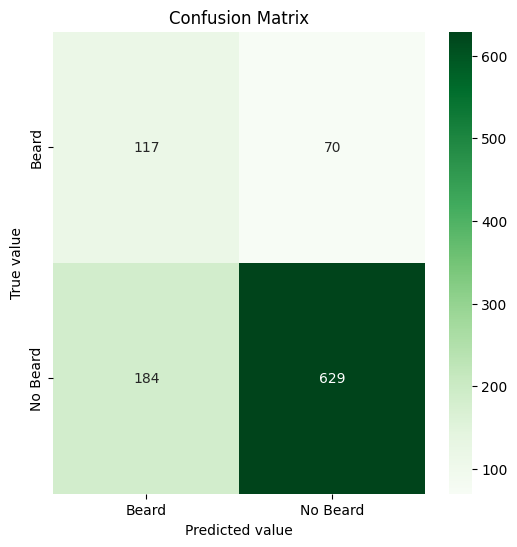

In [161]:
datasets_augmentation = (
    ('train_augmentation', datagen_augmentation.flow_from_dataframe(dataframe=df_train, **GENERATOR_PARAMS, batch_size=1000)),
    ('validation_augmentation', datagen_augmentation.flow_from_dataframe(dataframe=df_validation, **GENERATOR_PARAMS, batch_size=1000)),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    print('Samples:', len(batch_images))

    predictions = np.round(chosen_model_more_epochs.predict(batch_images)).flatten()
    labels = batch_labels

    print('Accuracy:', accuracy_score(labels, predictions))
    print('Precision:', precision_score(labels, predictions))
    print('ROC-AUC Score:', roc_auc_score(labels,predictions))

    VALORES = "Beard", "No Beard"

    plt.figure(figsize=(6,6))

    sns.heatmap(confusion_matrix(labels, predictions), annot=True, cmap='Greens', xticklabels=VALORES, yticklabels=VALORES, fmt='g')
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    plt.title('Confusion Matrix')
    plt.show()

In [162]:
chosen_model_more_epochs.save_weights("chosen_model_more_epochs.h5")

### Conclusiones reentrenamiento mejor modelo
Reentrenamos el modelo elegido utilizando esta vez como datos de entrenamiento las imágenes obtenidas aplicando técnicas de data-augmentation.

Realizamos dos entrenamientos, uno con 20 épocas y el otro con 50 para comparar resultados.
Para el primer caso, se obtuvieron valores en las métricas de accuracy de 0.62 y ROC-AUC Score de 0.67.
En el segundo caso, con 50 épocas, accuracy tomó un valor de 0.74 y ROC-AUC Score de aproximadamente 0.7.
Podemos ver que se fue ajustando los valores de las métricas a partir de mayor cantidad de épocas.

Respecto al modelo convolucional entrenado con imágenes sin aplicar aumentación de datos, vemos que los resultados difieren bastante, obteniendo mejores valores en las métricas.